# CountMatch Matcher Development
## Part 2: Reproducing Arman's 2011 Mean Absolute Error

This notebook investigates why our prototype in Part 1 produces a much noisier ground truth vs. predictions plot, and much worse mean absolute error, for 2011.

## Preprocess Data

These cells are copied from Part 1

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

import sklearn.metrics as sklm

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['key']

In [2]:
rdr = reader.Reader(vol_conn)
%time rdr.read()

CPU times: user 2min 3s, sys: 2.78 s, total: 2min 6s
Wall time: 2min 25s


In [3]:
gf.get_growth_factors(rdr)

In [4]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
%time nb.find_neighbours()

CPU times: user 18.4 s, sys: 594 ms, total: 19 s
Wall time: 18.5 s


In [5]:
def nanaverage(x, axis=None, weights=None):
    if weights is None:
        return np.nanmean(x)
    notnull = ~(np.isnan(x) | np.isnan(weights))
    return np.average(x[notnull], axis=axis, weights=weights[notnull])

def mse_preprocess_ptc_loop(p):
    available_years = p.data['Daily Count'].index.levels[0].values

    # Get ratio between AADT and daily count
    doyr = p.data['Daily Count'].loc[:, ['Date']].copy()
    for year in available_years:
        doyr.loc[year, 'Day-to-AADT Ratio'] = (
            p.data['AADT'].at[year, 'AADT'] /
            p.data['Daily Count'].loc[year, 'Daily Count']).values
    doyr.reset_index(inplace=True)
    doyr['Month'] = doyr['Date'].dt.month
    doyr['Day of Week'] = doyr['Date'].dt.dayofweek
    
    # Number of days of the week in each year and month.  Fill NaNs with
    # 0.
    N_days = (doyr.reset_index()
              .groupby(['Year', 'Month', 'Day of Week'])['Day-to-AADT Ratio']
              .count().unstack(fill_value=0.))

    # Create two arrays - first breaks down values by day-of-week and year.
    # First, get day-to-AADT ratios for each day of week and year.
    ptc_mse_ydow = pd.DataFrame(
        doyr.groupby(['Day of Week', 'Year'])['Day-to-AADT Ratio'].mean())

    # Then, for each day-of-week, calculate MADT, DoMADT, etc. averages
    # weighted by number of days-of-the-week available in the month.
    madt_avg = []
    dom_avg = []
    domadt_avg = []
    for dow, year in ptc_mse_ydow.index:
        # Double loc is shortest way I've discovered to get single-index
        # series.
        weights = N_days.loc[year, :].loc[:, dow]

        madt_avg.append(np.average(
            p.data['MADT'].loc[year, 'MADT'][weights.index].values,
            weights=weights.values))
        dom_avg.append(nanaverage(
            p.data['DoM Factor'].loc[year, :].loc[weights.index, dow],
            weights=weights.values))
        domadt_avg.append(nanaverage(
            p.data['DoMADT'].loc[year, :].loc[weights.index, dow],
            weights=weights.values))
        
    ptc_mse_ydow['MADT Avg.'] = madt_avg
    ptc_mse_ydow['DoM Factor Avg.'] = dom_avg
    ptc_mse_ydow['DoMADT Avg.'] = domadt_avg
    
    if (ptc_mse_ydow['MADT Avg.'].isnull().values.any() or
            ptc_mse_ydow['DoM Factor Avg.'].isnull().values.any() or
            ptc_mse_ydow['DoM Factor Avg.'].isnull().values.any()):
        raise ValueError("yeah, you shouldn't be getting nulls for ydow tables.")

    # Now, create a second array that breaks down the same values but only
    # by year.
    ptc_mse_yo = pd.DataFrame(doyr.groupby('Year')['Day-to-AADT Ratio'].mean())

    madt_avg = []
    dom_avg = []
    domadt_avg = []
    for year in ptc_mse_yo.index:
        n_days_year = N_days.loc[year, :]
        madt_weights = n_days_year.sum(axis=1, skipna=True)

        madt_avg.append(np.average(
            p.data['MADT'].loc[year, 'MADT'][madt_weights.index].values,
            weights=madt_weights.values))

        dom_year = p.data['DoM Factor'].loc[year, :]
        dom_avg.append(nanaverage(
            dom_year.values, weights=n_days_year.values))
        domadt_avg.append(nanaverage(
            p.data['DoMADT'].loc[year, :].values, weights=n_days_year.values))

    ptc_mse_yo['MADT Avg.'] = madt_avg
    ptc_mse_yo['DoM Factor Avg.'] = dom_avg
    ptc_mse_yo['DoMADT Avg.'] = domadt_avg

    if (ptc_mse_yo['MADT Avg.'].isnull().values.any() or
            ptc_mse_yo['DoM Factor Avg.'].isnull().values.any() or
            ptc_mse_yo['DoM Factor Avg.'].isnull().values.any()):
        raise ValueError("yeah, you shouldn't be getting nulls for yo tables.")

    return doyr, ptc_mse_ydow, ptc_mse_yo

def mse_preprocess_ptcs(ptcs):
    for p in ptcs.values():
        doyr, ptc_mse_ydow, ptc_mse_yo = mse_preprocess_ptc_loop(p)
        p.mse_pp = {
            'Day-to-AADT': doyr,
            'MSE_yDoW': ptc_mse_ydow,
            'MSE_y': ptc_mse_yo
        }

In [6]:
%time mse_preprocess_ptcs(rdr.ptcs)

CPU times: user 10.8 s, sys: 78.1 ms, total: 10.8 s
Wall time: 10.8 s


In [7]:
def get_normalized_seasonal_patterns(tcs, rptcs, want_year):
    """Get normalized seasonal patterns for `tcs`.

    For STTCs, get best estimate normalized patterns and corresponding PTC
    normalized patterns to check for MSE (Eqn. 6 in Bagheri).  For PTCs, get
    best estimate from nearby PTCs and check as a part of validation.
    """
    growth_rate_citywide = np.mean([v.growth_factor for v in rptcs.values()])

    for tc in tcs.values():
        # Find neighbouring PTCs by first finding neighbouring centreline IDs,
        # then checking if either direction exists in rptcs.
        neighbours, distances = nb.get_neighbours(tc.centreline_id)
        
        # We can consider both directions if we want, but this is supposed
        # to emulate PRTCS.
#         neighbour_ptcs = [rptcs[n] for n in
#                           [-nbrs for nbrs in neighbours] + neighbours
#                           if n in rptcs.keys()]
        neighbour_ptcs = [rptcs[n] for n in
                          [tc.direction * nbrs for nbrs in neighbours]
                          if n in rptcs.keys()][:5]

        if len(neighbour_ptcs) != 5:
            raise ValueError("selected a weird number of PTC locations!")

        # Declare the columns in the final saved data frame.
        tc_year = []
        tc_dayofyear = []
        tc_ptcid = []
        tc_day_to_aadt_ratio_avg = []
        tc_madt_avg = []
        tc_dom_avg = []
        tc_domadt_avg = []
        tc_closest_year = []
        tc_aadt_closest_year = []

        if tc.is_permanent:
            tc_dc = tc.data['Daily Count'].reset_index()
        else:
            tc_dc = tc.data.reset_index()
        tc_dc['Day of Week'] = tc_dc['Date'].dt.dayofweek

        for i, row in tc_dc.iterrows():
            ryear, rdow = row['Year'], row['Day of Week']

            for p in neighbour_ptcs:

                if rdow in p.mse_pp['MSE_yDoW'].index.levels[0]:
                    unique_years = p.mse_pp['MSE_yDoW'].loc[rdow].index.values
                    closest_year = unique_years[np.argmin(
                        np.abs(unique_years - ryear))]

                    (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
                       p.mse_pp['MSE_yDoW'].loc[(rdow, closest_year)])
                else:
                    # Levels contain all unique years regardless if each is
                    # available for every day-of-week.
                    unique_years = p.mse_pp['MSE_yDoW'].index.levels[1].values
                    closest_year = unique_years[np.argmin(
                        np.abs(unique_years - ryear))]

                    (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
                       p.mse_pp['MSE_y'].loc[closest_year])
                
                if madt_avg is np.nan:
                    raise ValueError("ummmmm, this can't be NaN.")

                aadt_closest_year = p.data['AADT'].at[closest_year, 'AADT']

                tc_year.append(ryear)
                tc_dayofyear.append(row['Day of Year'])
                tc_ptcid.append(p.count_id)
                tc_day_to_aadt_ratio_avg.append(day_to_aadt_ratio_avg)
                tc_madt_avg.append(madt_avg)
                tc_dom_avg.append(dom_avg)
                tc_domadt_avg.append(domadt_avg)
                tc_closest_year.append(closest_year)
                tc_aadt_closest_year.append(aadt_closest_year)

        tc_mse = pd.DataFrame({
            'Year': tc_year,
            'Day of Year': tc_dayofyear,
            'PTC ID': tc_ptcid,
            'PTC Day-to-AADT Ratio': tc_day_to_aadt_ratio_avg,
            'PTC MADT Avg.': tc_madt_avg,
            'PTC DoM Factor Avg.': tc_dom_avg,
            'PTC DoMADT Avg.': tc_domadt_avg,
            'PTC Closest Year AADT': tc_aadt_closest_year
        })

        tc_mse = pd.merge(tc_dc, tc_mse, on=('Year', 'Day of Year'))

        # I disagree with this, but line 95 of DoMSTTC.m seems to do it.
        mean_tc_count = tc_dc['Daily Count'].mean()

        tc_mse['AADT_prelim'] = (
            mean_tc_count * tc_mse['PTC Day-to-AADT Ratio'] *
            growth_rate_citywide**(want_year - tc_mse['Year']))
        tc_mse['MADT_pj'] = (
            tc_mse['Daily Count'] * tc_mse['PTC DoM Factor Avg.'] *
            growth_rate_citywide**(want_year - tc_mse['Year']))
        tc_mse['MF_STTC'] = tc_mse['MADT_pj'] / tc_mse['AADT_prelim']
        tc_mse['MF_PTC'] = (tc_mse['PTC MADT Avg.'] /
                            tc_mse['PTC Closest Year AADT'])

        tc.tc_mse = tc_mse

## Estimate Errors for 2011

In [8]:
want_year = 2011

In [9]:
%time get_normalized_seasonal_patterns(rdr.ptcs, rdr.ptcs, want_year)

CPU times: user 4min 28s, sys: 93.8 ms, total: 4min 28s
Wall time: 4min 28s


In [72]:
for tc in rdr.ptcs.values():
    tc.tc_mse = pd.merge(tc.tc_mse, tc.data['AADT'],
                         how='left', left_on='Year', right_index=True)    

In [73]:
# def get_aadt_estimates_ptc(rdr, want_year):
ptc_count_id = []
ptc_ptc_id_minmse = []
ptc_dij_minmse = []
ptc_closest_year = []
ptc_aadt_est = []
ptc_aadt_actual = []
ptc_sttc_daily_count = []

for tc in rdr.ptcs.values():   
    # Calculate pointwise square error between STTC and neighbouring PTCs,
    # ignoring year.
    tc.tc_mse['Square Deviation'] = (
        tc.tc_mse['MF_STTC'] - tc.tc_mse['MF_PTC'])**2

    # Determine minimum MSE between STTC and each PTC.
    dijs = (tc.tc_mse
            .groupby('PTC ID')[['Square Deviation',
                                'PTC Day-to-AADT Ratio']]
            .mean())
    ptcid_mmse = dijs['Square Deviation'].idxmin()
    dij_mmseptc = dijs.at[ptcid_mmse, 'PTC Day-to-AADT Ratio']

    # Determine average daily count for most recent year to wanted year.
    sttc_years = tc.data['AADT'].index.values
    closest_year = sttc_years[np.abs(want_year - sttc_years).argmin()]
    sttc_daily_count_cyavg = tc.data['Daily Count'].loc[closest_year]['Daily Count'].mean()

    aadt_estimate = (
        sttc_daily_count_cyavg * dij_mmseptc *
        tc.growth_factor**(want_year - closest_year))
    
    aadt_actual = tc.tc_mse.groupby('PTC ID')['AADT'].mean()[ptcid_mmse]

    # Add to lists.
    ptc_count_id.append(tc.count_id)
    ptc_ptc_id_minmse.append(ptcid_mmse)
    ptc_sttc_daily_count.append(sttc_daily_count_cyavg)
    ptc_dij_minmse.append(dij_mmseptc)
    ptc_closest_year.append(closest_year)
    ptc_aadt_est.append(aadt_estimate)
    ptc_aadt_actual.append(aadt_actual)

ptc_validation_aadt = pd.DataFrame({
    'Count ID': ptc_count_id,
    'Mean Daily Count': ptc_sttc_daily_count,
    'PTC ID': ptc_ptc_id_minmse,
    'D_ij': ptc_dij_minmse,
    'Closest Year': ptc_closest_year,
    'AADT Estimate': ptc_aadt_est,
    'AADT Actual': ptc_aadt_actual})

KeyError: 'Column not found: AADT'

(0, 100000)

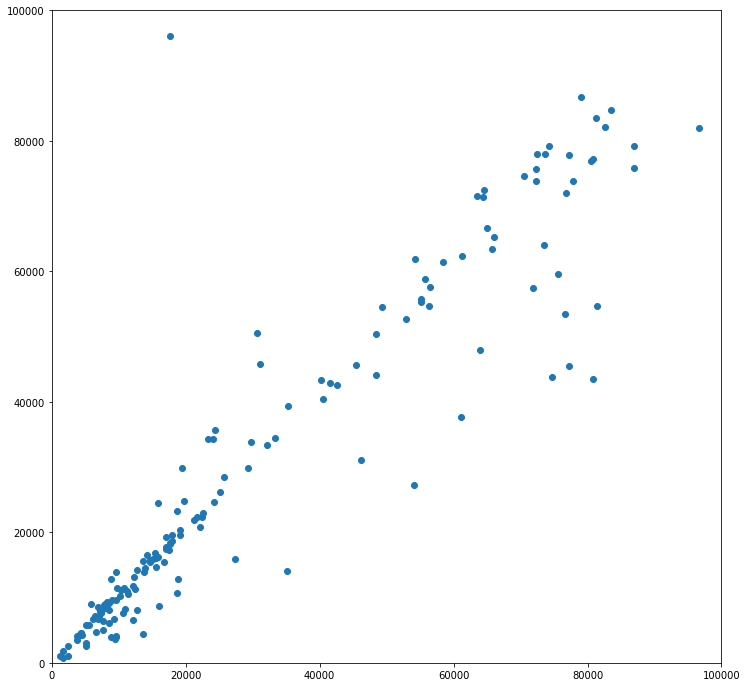

In [74]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(ptc_validation_aadt['AADT Actual'], ptc_validation_aadt['AADT Estimate'],
        marker='o', ls='None')
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])

In [75]:
sklm.mean_absolute_error(ptc_validation_aadt['AADT Estimate'], ptc_validation_aadt['AADT Actual'])

5774.832038949777

In [76]:
np.mean(
    np.abs(ptc_validation_aadt['AADT Actual'] - ptc_validation_aadt['AADT Estimate']) /
    ptc_validation_aadt['AADT Actual'])

0.24648518145427775

In [77]:
ptc_validation_aadt['Absolute Deviation'] = np.abs(
    ptc_validation_aadt['AADT Estimate'] - ptc_validation_aadt['AADT Actual'])

In [87]:
ptc_validation_aadt.loc[ptc_validation_aadt['Count ID'] < 0, :].sort_values('Absolute Deviation', ascending=False).head(20)

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Actual,Absolute Deviation
147,-445884,64677.762542,-445309,1.009202,2016,105171.458504,64882.736826,40288.721678
144,-1022,80716.531690,-445884,1.014712,2016,43439.559220,80808.505018,37368.945798
127,-440332,73094.273333,-442447,1.010104,2015,45444.327586,77299.795694,31855.468108
142,-30003565,54113.130909,-14659244,1.026642,2015,27273.279828,54092.216417,26818.936589
46,-1147347,30707.932660,-13515818,1.084328,2010,50622.108235,30578.572598,20043.535637
160,-14659244,61944.451049,-6388019,1.015671,2016,47901.697066,64017.762598,16116.065531
146,-441170,95209.233227,-442447,1.010766,2016,82053.134034,96587.976205,14534.842171
153,-8491741,13659.230284,-1147201,1.054257,2016,4420.128311,13632.425063,9212.296751
76,-13515818,18616.104918,-30022069,1.022295,2010,10633.495353,18739.428062,8105.932709
13,-443975,85027.156352,-442915,1.053140,2010,86807.555333,78977.804873,7829.750460


In [79]:
ptc_validation_aadt['Count ID'].sort_values().values

array([-30087988, -30085896, -30073761, -30073545, -30036166, -30023559,
       -30022069, -30021784, -30016282, -30010427, -30003565, -20140757,
       -20054568, -20050591, -20037402, -14659244, -14255077, -14073969,
       -13975074, -13975065, -13515818, -13503833, -13503251, -13503207,
       -13503206, -12763897, -12387683, -12336171, -12336156, -12334941,
       -12334937, -12334629, -12334583, -11129605, -10924071,  -9637988,
        -9313402,  -9212691,  -8491741,  -6837741,  -6436449,  -6388019,
        -1147466,  -1147434,  -1147347,  -1147316,  -1147234,  -1147201,
        -1147184,  -1147113,  -1146997,  -1146615,  -1146568,  -1146358,
        -1146335,  -1146214,  -1146202,  -1145667,  -1145405,  -1145202,
        -1144036,  -1141572,   -913864,   -445884,   -445309,   -444637,
         -443987,   -443975,   -442915,   -442447,   -442161,   -441170,
         -440946,   -440789,   -440332,   -440171,   -110101,   -106797,
         -104870,     -8171,     -1022,      -890, 

# -890

In [80]:
def get_actual_neighbours(tc, rptcs):
    """Since bidirectional neighbours are stored in nb.data,
    show only the five nearest same-direction links."""
    neighbours, distances = nb.get_neighbours(tc.centreline_id)
    return [rptcs[n].centreline_id for n in
            [tc.direction * nbrs for nbrs in neighbours]
            if n in rptcs.keys()][:5]

In [81]:
ptc_validation_aadt.loc[ptc_validation_aadt['Count ID'] == -890, :]

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Actual,Absolute Deviation
1,-890,70596.744681,-445884,1.017,2010,74577.34597,70583.48078,3993.86519


In [65]:
get_actual_neighbours(rdr.ptcs[-890], rdr.ptcs)

[1022, 445884, 10924071, 445309, 444637]

For TEPS,

```
id = 890
aadt_true = 70563.92888
aadt_pred = 68310.77547
```

which is a 3% error rather than a 5% one like CountMatch's.

I used this

```matlab
v1(j); % this PTC
curr_mses = MSE(MSE(:,2)==v1(j),:); % MSE table
iDoMs(curr_mses(iminMSE, 1)) % nearest PTC matched with this PTC
```

to discover the nearest PTC selected by TEPS is `10924071` instead of `445884`. that CountMatch selected.  `10924071` is Greenwood Ave. rather than another section of the DVP like `445884`.  However, this changes `D_ij` from 1.0159 in TEPS to 1.017 in CountMatch.  The real difference appears to be `sttc_daily_count_cyavg`, which is 68004 in TEPS but 70596 in CountMatch because we have more data.

## -13515818